In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.0405982905982906

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

19

In [9]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [10]:
df_encoded=df_encoded.dropna()

In [11]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

In [12]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

In [13]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

In [14]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

In [15]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

In [16]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

In [17]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

In [18]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [19]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [20]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,550.0,11.0,80.0,11,1,True,False,False,False,False,...,False,False,False,1,405.0,1,0.599888,0.5,0.599888,60.50
1,293.0,7.0,60.0,8,1,True,False,False,False,False,...,False,False,False,1,415.0,1,0.602286,1.0,0.602286,20.51
2,1500.0,13.0,80.0,2,4,False,False,False,True,False,...,False,False,False,1,182.0,1,0.545375,0.7,0.545375,195.00
3,15000.0,6.0,50.0,9,50,False,False,False,True,True,...,False,False,False,0,0.0,1,0.000000,0.3,1.000000,900.00
4,2980.0,12.0,80.0,5,8,False,False,False,True,False,...,False,False,False,0,0.0,1,0.000000,2.4,1.000000,357.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.00
464,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.00
465,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.00
466,1600.0,15.0,80.0,8,6,False,False,False,True,True,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.00


In [21]:
poly = PolynomialFeatures(2, include_bias=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [22]:
X

,1,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",...,sving_sigmoid^2,sving_sigmoid bakke,sving_sigmoid bakke_sigmoid,sving_sigmoid antall_lange_kj,bakke^2,bakke bakke_sigmoid,bakke antall_lange_kj,bakke_sigmoid^2,bakke_sigmoid antall_lange_kj,antall_lange_kj^2
0,1.0,550.0,11.0,80.0,11.0,1.0,1.0,0.0,0.0,0.0,...,0.359866,0.299944,0.359866,36.293246,0.25,0.299944,30.25,0.359866,36.293246,3660.2500
1,1.0,293.0,7.0,60.0,8.0,1.0,1.0,0.0,0.0,0.0,...,0.362749,0.602286,0.362749,12.352889,1.00,0.602286,20.51,0.362749,12.352889,420.6601
2,1.0,1500.0,13.0,80.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.297434,0.381762,0.297434,106.348090,0.49,0.381762,136.50,0.297434,106.348090,38025.0000
3,1.0,15000.0,6.0,50.0,9.0,50.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.09,0.300000,270.00,1.000000,900.000000,810000.0000
4,1.0,2980.0,12.0,80.0,5.0,8.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,5.76,2.400000,858.24,1.000000,357.600000,127877.7600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,1.0,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,...,0.673283,0.410269,0.673283,64.002001,0.25,0.410269,39.00,0.673283,64.002001,6084.0000
452,1.0,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,...,0.568219,0.150761,0.568219,37.690159,0.04,0.150761,10.00,0.568219,37.690159,2500.0000
453,1.0,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,...,0.300143,3.013192,0.300143,28.488360,30.25,3.013192,286.00,0.300143,28.488360,2704.0000
454,1.0,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,...,0.394488,1.884248,0.394488,150.739830,9.00,1.884248,720.00,0.394488,150.739830,57600.0000


In [23]:
print("Totalt etter interaksjoner:", len(X.columns))

Totalt etter interaksjoner: 528


In [24]:
#X=df_with_interactions
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [25]:
X

,1,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",...,sving_sigmoid^2,sving_sigmoid bakke,sving_sigmoid bakke_sigmoid,sving_sigmoid antall_lange_kj,bakke^2,bakke bakke_sigmoid,bakke antall_lange_kj,bakke_sigmoid^2,bakke_sigmoid antall_lange_kj,antall_lange_kj^2
0,0.0,0.029662,0.2,0.666667,0.142857,0.000000,1.0,0.0,0.0,0.0,...,0.179589,0.005251,0.179589,0.529829,-0.238636,-0.456301,-0.264350,-0.352495,-0.056164,0.041102
1,0.0,-0.252678,-0.6,0.000000,-0.285714,0.000000,1.0,0.0,0.0,0.0,...,0.186809,0.177020,0.186809,-0.041904,-0.185369,-0.331179,-0.301965,-0.348143,-0.367092,-0.168506
2,0.0,1.073332,0.6,0.666667,-1.142857,1.333333,0.0,0.0,0.0,1.0,...,0.023219,0.051735,0.023219,2.202847,-0.221591,-0.422441,0.145981,-0.446746,0.853683,2.264568
3,0.0,15.904422,-0.8,-0.333333,-0.142857,21.777778,0.0,0.0,0.0,1.0,...,-0.721742,-0.165155,-0.721742,-0.336910,-0.250000,-0.456278,0.661550,0.613884,11.161344,52.212841
4,0.0,2.699258,0.4,0.666667,-0.714286,3.111111,0.0,0.0,0.0,1.0,...,-0.721742,-0.165155,-0.721742,-0.336910,0.152699,0.412795,2.933295,0.613884,4.116851,8.078215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.0,0.853612,-0.8,-1.000000,1.571429,-0.444444,1.0,0.0,0.0,0.0,...,0.964584,0.067930,0.964584,1.191557,-0.238636,-0.410644,-0.230558,0.120656,0.303708,0.197923
452,0.0,-0.025268,0.0,0.000000,0.285714,0.444444,0.0,0.0,1.0,0.0,...,0.701437,-0.079504,0.701437,0.563189,-0.253551,-0.518040,-0.342554,-0.037954,-0.038021,-0.033969
453,0.0,-0.135128,0.6,0.000000,0.285714,-0.444444,0.0,0.0,0.0,1.0,...,0.030005,1.546722,0.030005,0.343436,1.892045,0.666562,0.723341,-0.442656,-0.157531,-0.020769
454,0.0,1.183191,1.0,0.666667,-0.285714,2.222222,0.0,0.0,0.0,1.0,...,0.266304,0.905338,0.266304,3.262990,0.382813,0.199354,2.399421,-0.300228,1.430227,3.531108


In [26]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances
# Select top 10 features
top_features = importances_sorted.index[:15]
X_top = X[top_features]

In [27]:
importances_sorted

ÅDT, total Avkjørsler                                                           0.015065
ÅDT, total bakke                                                                0.013625
Fartsgrense bakke                                                               0.013409
Avkjørsler bakke_sigmoid                                                        0.013365
bakke antall_lange_kj                                                           0.013231
                                                                                  ...   
EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk EGS.BRUKSOMRÅDE.1256_Naust              0.000000
EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk EGS.BRUKSOMRÅDE.1256_Service            0.000000
EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk EGS.BRUKSOMRÅDE.1256_Skog/skogbruk      0.000000
EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage    0.000000
Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Naust                    0.000000
Length: 528, dtype: f

In [28]:
X=X_top

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [30]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [31]:
yps=model.predict_proba(X_test)

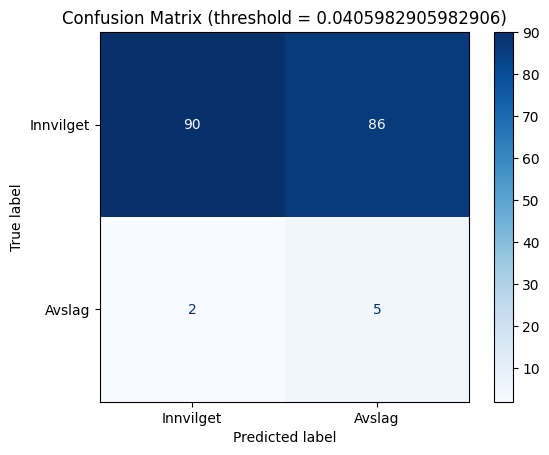

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = andel_avslag # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [33]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     0.9783    0.5114    0.6716       176
           1     0.0549    0.7143    0.1020         7

    accuracy                         0.5191       183
   macro avg     0.5166    0.6128    0.3868       183
weighted avg     0.9429    0.5191    0.6499       183



In [34]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [35]:
yps=model.predict_proba(X_test)

In [36]:
X_test

,"ÅDT, total Avkjørsler","ÅDT, total bakke",Fartsgrense bakke,Avkjørsler bakke_sigmoid,bakke antall_lange_kj,Fartsgrense Avkjørsler,"ÅDT, andel lange kjøretøy Avkjørsler","ÅDT, andel lange kjøretøy bakke_sigmoid",Avkjørsler bakke,bakke_sigmoid antall_lange_kj,Avkjørsler antall_lange_kj,"ÅDT, total antall_lange_kj",Fartsgrense antall_lange_kj,bakke,bakke_ind bakke_sigmoid
373,0.000000,-0.144667,-0.079602,0.298808,-0.172629,0.300,-0.226190,0.188043,-0.116788,0.056917,-0.090349,-0.033184,0.056286,-0.21875,0.655431
39,-0.180823,-0.074586,0.089552,-0.004956,-0.175231,-0.250,-0.357143,-0.586340,0.376318,-0.341753,-0.314010,-0.137315,-0.346235,0.21875,-0.016280
340,1.742586,1.295939,0.089552,0.255676,0.831784,0.125,0.047619,-0.496162,0.629359,0.523923,1.213581,0.976565,0.437777,0.21875,-0.076729
218,4.514829,0.093557,-0.432836,0.436414,0.151774,0.875,1.523810,-0.326474,-0.158962,1.343577,5.323857,3.833225,1.651045,-0.43750,-0.405702
155,-0.034552,0.050244,0.636816,0.748633,0.024330,0.900,0.238095,0.376085,0.700730,-0.072960,-0.073566,-0.097909,-0.068794,0.34375,0.655431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-0.278722,0.087493,2.268657,0.898574,0.276901,1.100,1.130952,1.316299,2.527170,-0.215824,-0.194403,-0.151014,-0.206381,1.62500,0.655431
193,0.241866,0.219166,0.039801,0.134386,0.174946,-0.125,0.119048,-0.153267,0.389294,0.032365,0.194963,0.052062,-0.037524,0.15625,0.030520
351,0.684135,0.047645,-0.288557,0.298808,-0.018306,-0.150,-0.226190,0.188043,-0.204380,0.828382,0.507799,0.589457,0.472799,-0.31250,0.655431
399,-0.376044,-0.383151,-0.477612,-0.300957,-0.343017,-0.500,0.000000,2.256512,-0.434712,0.114062,-0.267130,-0.098213,0.111320,-0.53125,0.655431


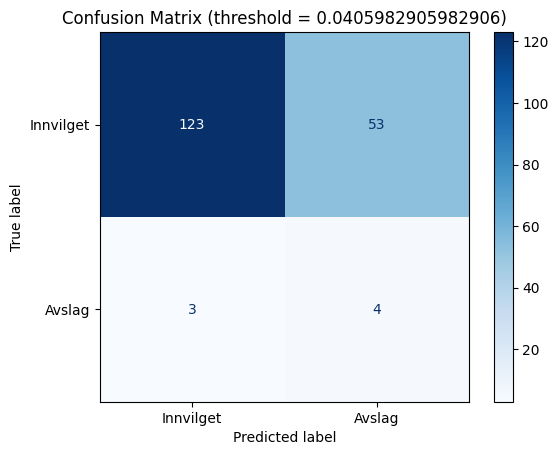

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = andel_avslag # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [38]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     0.9915    0.6591    0.7918       176
           1     0.0909    0.8571    0.1644         7

    accuracy                         0.6667       183
   macro avg     0.5412    0.7581    0.4781       183
weighted avg     0.9570    0.6667    0.7678       183



In [39]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [40]:
print(importances_sorted)

Avkjørsler bakke_sigmoid                   0.088110
ÅDT, total Avkjørsler                      0.086836
bakke antall_lange_kj                      0.072337
ÅDT, total bakke                           0.071921
bakke_sigmoid antall_lange_kj              0.070306
Avkjørsler antall_lange_kj                 0.069835
Fartsgrense bakke                          0.069009
Fartsgrense Avkjørsler                     0.066122
ÅDT, total antall_lange_kj                 0.065595
Fartsgrense antall_lange_kj                0.065474
Avkjørsler bakke                           0.063452
ÅDT, andel lange kjøretøy Avkjørsler       0.058701
ÅDT, andel lange kjøretøy bakke_sigmoid    0.055336
bakke                                      0.051246
bakke_ind bakke_sigmoid                    0.045722
dtype: float64


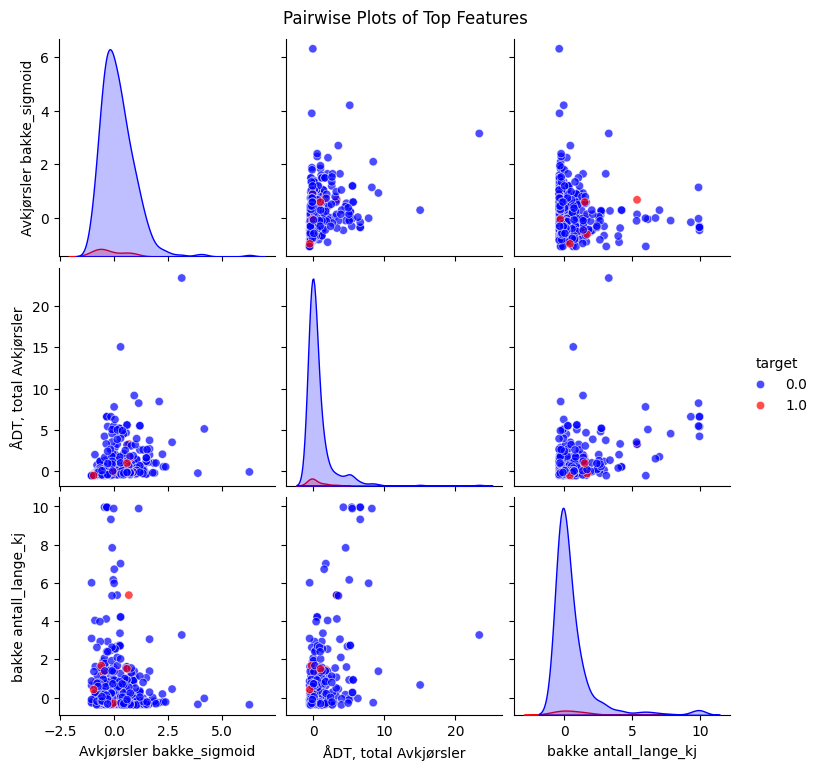

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X[top_features].copy()
X_top['target'] = y  # add the target

# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

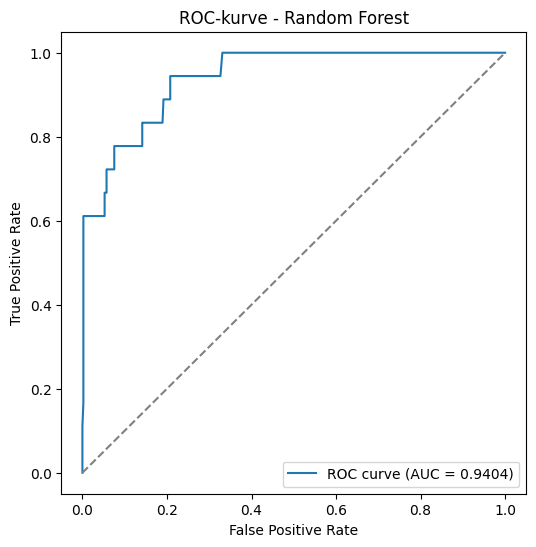

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [43]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.